In [1]:
import matplotlib.pyplot as plt
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks

np.random.seed(0)

# LOADING DATA

In [2]:
data = pd.read_csv("/content/weatherAUS.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


**About the data:**

The dataset contains about 10 years of daily weather observations from different locations across Australia. Observations were drawn from numerous weather stations.

In this project, I will use this data to predict whether or not it will rain the next day. There are 23 attributes including the target variable "RainTomorrow", indicating whether or not it will rain the next day or not.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null


 # DATA VISUALIZATION AND CLEANING

**Steps involves in this section:**

* Count plot of target column
* Correlation amongst numeric attributes
* Parse Dates into datetime
* Encoding days and months as continuous cyclic features


<ipython-input-4-9f925fcff129>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x= data["RainTomorrow"], palette= cols)


<Axes: xlabel='RainTomorrow', ylabel='count'>

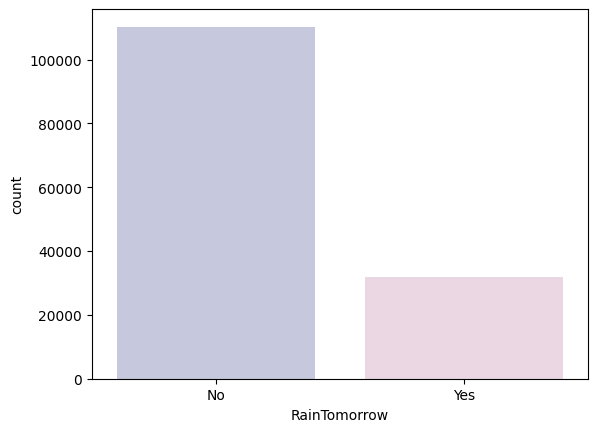

In [4]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
cols= ["#C2C4E2","#EED4E5"]
sns.countplot(x= data["RainTomorrow"], palette= cols)

**Now I will parse Dates into datetime.**

My goal is to build an artificial neural network(ANN). I will encode dates appropriately, i.e. I prefer the months and days in a cyclic continuous feature. As, date and time are inherently cyclical. To let the ANN model know that a feature is cyclical I split it into periodic subsections. Namely, years, months and days. Now for each subsection, I create two new features, deriving a sine transform and cosine transform of the subsection feature.

In [6]:
#Parsing datetime
#exploring the length of date objects
lengths = data["Date"].str.len()
lengths.value_counts()

,count
Date,
10,145460


In [7]:
#There don't seem to be any error in dates so parsing values into datetime
data['Date']= pd.to_datetime(data["Date"])
#Creating a collumn of year
data['year'] = data.Date.dt.year

# function to encode datetime into cyclic parameters.
#As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature.

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

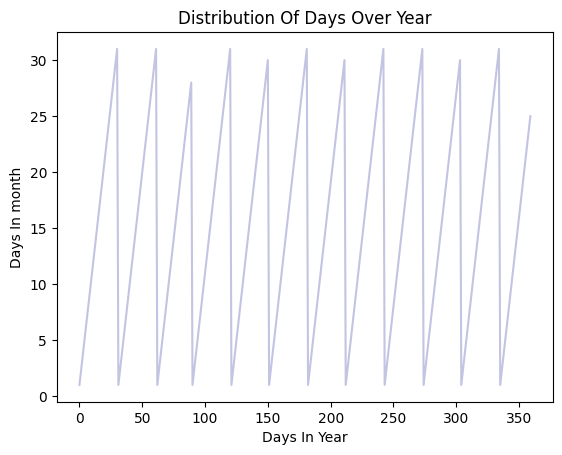

In [8]:
# roughly a year's span section
section = data[:360]
tm = section["day"].plot(color="#C2C4E2")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

As expected, the "year" attribute of data repeats. However in this for the true cyclic nature is not presented in a continuous manner. Splitting months and days into Sine and cosine combination provides the cyclical continuous feature. This can be used as input features to ANN.

Text(0.5, 0, 'Sine Encoded Months')

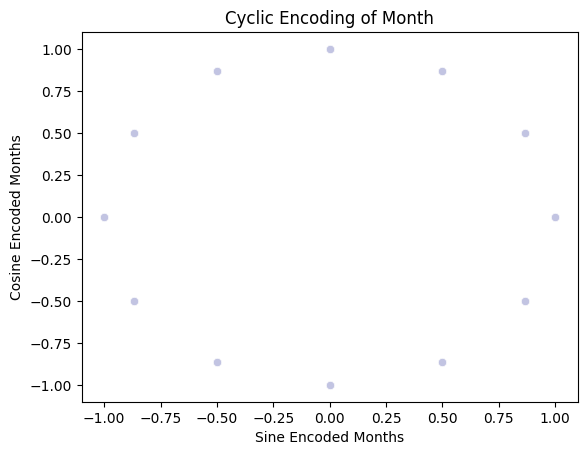

In [9]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")


Text(0.5, 0, 'Sine Encoded Day')

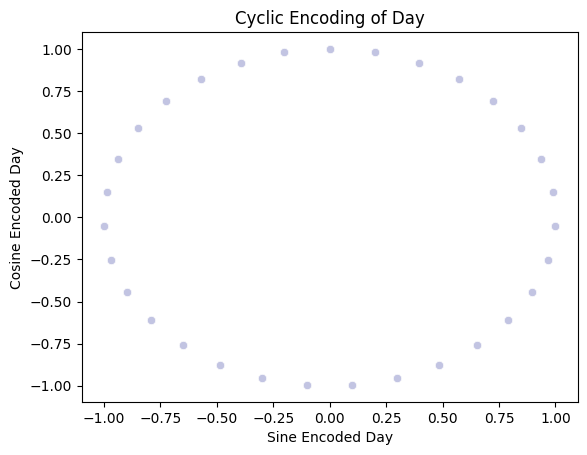

In [10]:
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

Next, I will deal with missing values in categorical and numeric attributes separately

**Categorical variables**

* Filling missing values with mode of the column value

In [11]:
# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [12]:
# Missing values in categorical variables

for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


In [13]:
# Filling missing values with mode of the column in value

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

<ipython-input-13-c47c2d6da7f2>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[i].fillna(data[i].mode()[0], inplace=True)


**Numerical variables**

* Filling missing values with median of the column value

In [14]:
# Get list of neumeric variables
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [15]:
# Missing values in numeric variables

for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [16]:
# Filling missing values with median of the column in value

for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)

data.info()

<ipython-input-16-4b03adfd6c01>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[i].fillna(data[i].median(), inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  object        
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  object        
 10  WindDir3pm     145460 non-null  object        
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

Text(0.5, 0, 'Years')

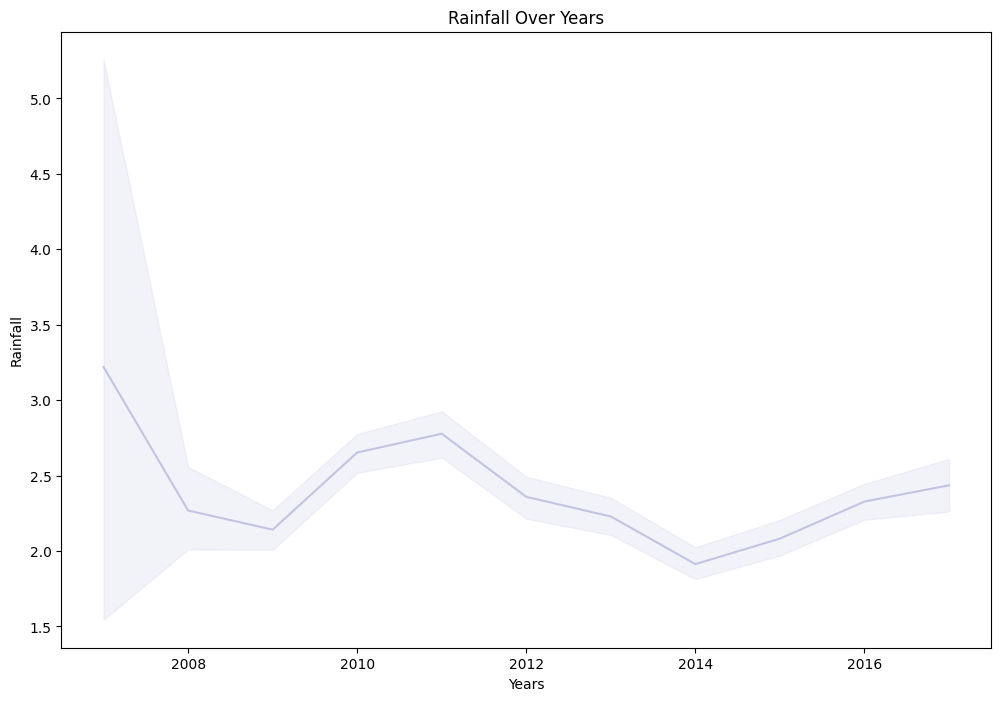

In [17]:
#plotting a lineplot rainfall over years
plt.figure(figsize=(12,8))
Time_series=sns.lineplot(x=data['Date'].dt.year,y="Rainfall",data=data,color="#C2C4E2")
Time_series.set_title("Rainfall Over Years")
Time_series.set_ylabel("Rainfall")
Time_series.set_xlabel("Years")

<ipython-input-18-98c985829d42>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)
<ipython-input-18-98c985829d42>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)
<ipython-input-18-98c985829d42>:4: UserWarning: 
The palette list has fewer values (5) than needed (11) and will cycle, which may produce an uninterpretable plot.
  Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)


Text(0.5, 0, 'Year')

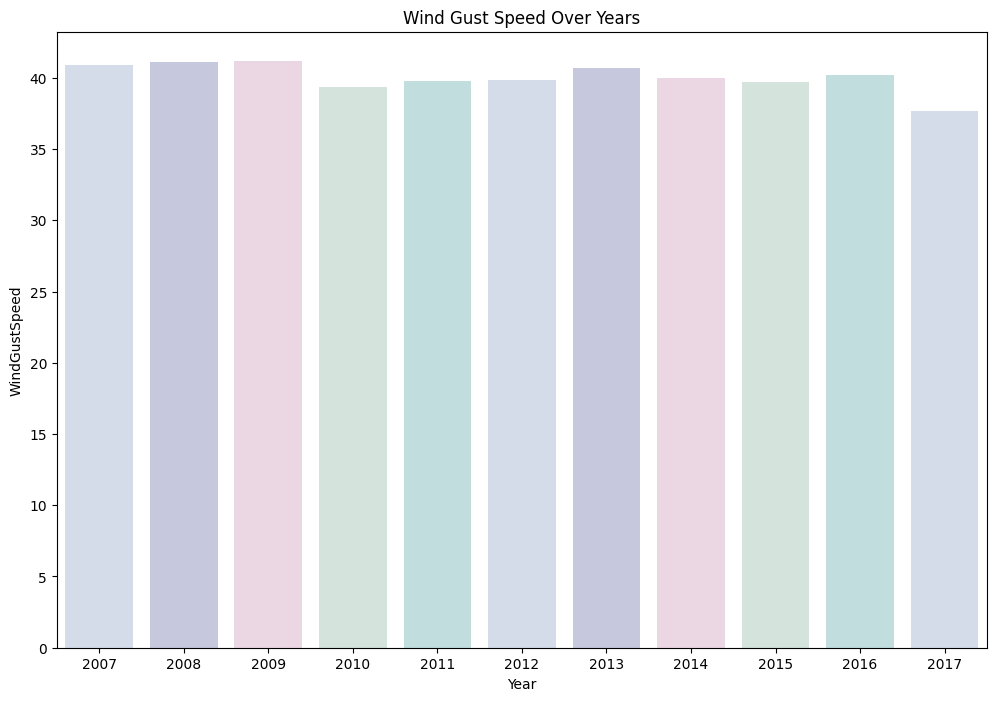

In [18]:
#Evauating Wind gust speed over years
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(12,8))
Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)
Days_of_week.set_title("Wind Gust Speed Over Years")
Days_of_week.set_ylabel("WindGustSpeed")
Days_of_week.set_xlabel("Year")


 # DATA PREPROCESSING

**Steps involved in Data Preprocessing:**

* Label encoding columns with categorical data
* Perform the scaling of the features
* Detecting outliers
* Dropping the outliers based on data analysis

**Label encoding the catagorical varable**

In [19]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  int64         
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  int64         
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  int64         
 10  WindDir3pm     145460 non-null  int64         
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

In [20]:
# Prepairing attributes of scale data

features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,145460.0,7.815677e-18,1.000003,-1.672228,-0.899139,0.014511,0.857881,1.701250
MinTemp,145460.0,-4.501830e-16,1.000003,-3.250525,-0.705659,-0.030170,0.723865,3.410112
MaxTemp,145460.0,3.001220e-16,1.000003,-3.952405,-0.735852,-0.086898,0.703133,3.510563
Rainfall,145460.0,7.815677e-18,1.000003,-0.275097,-0.275097,-0.275097,-0.203581,43.945571
Evaporation,145460.0,-3.282584e-17,1.000003,-1.629472,-0.371139,-0.119472,0.006361,43.985108
Sunshine,145460.0,-5.424080e-16,1.000003,-2.897217,0.076188,0.148710,0.257494,2.360634
WindGustDir,145460.0,6.252542e-18,1.000003,-1.724209,-0.872075,0.193094,1.045228,1.471296
WindGustSpeed,145460.0,1.824961e-16,1.000003,-2.588407,-0.683048,-0.073333,0.460168,7.243246
WindDir9am,145460.0,7.190423e-17,1.000003,-1.550000,-0.885669,0.000105,0.885879,1.771653
WindDir3pm,145460.0,8.284618e-17,1.000003,-1.718521,-0.837098,0.044324,0.925747,1.586813


<ipython-input-21-6d42aad80754>:5: UserWarning: 
The palette list has fewer values (5) than needed (26) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)


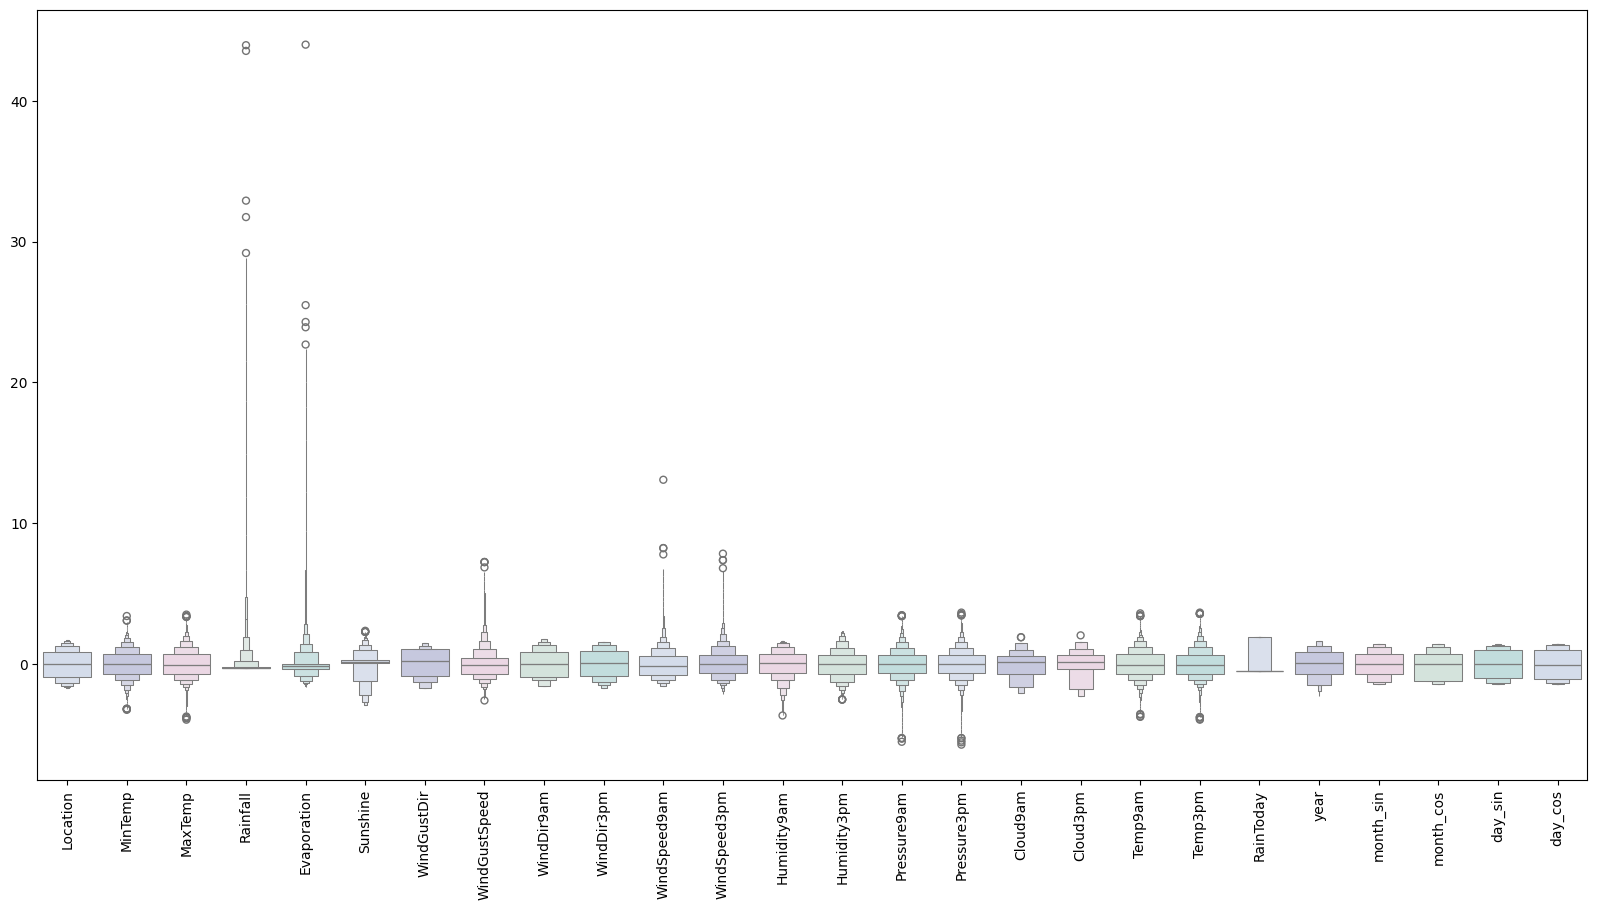

In [21]:
#Detecting outliers
#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [22]:
#full data for
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(127536, 27)

<ipython-input-23-0b9d7aa52ee8>:4: UserWarning: 
The palette list has fewer values (5) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)


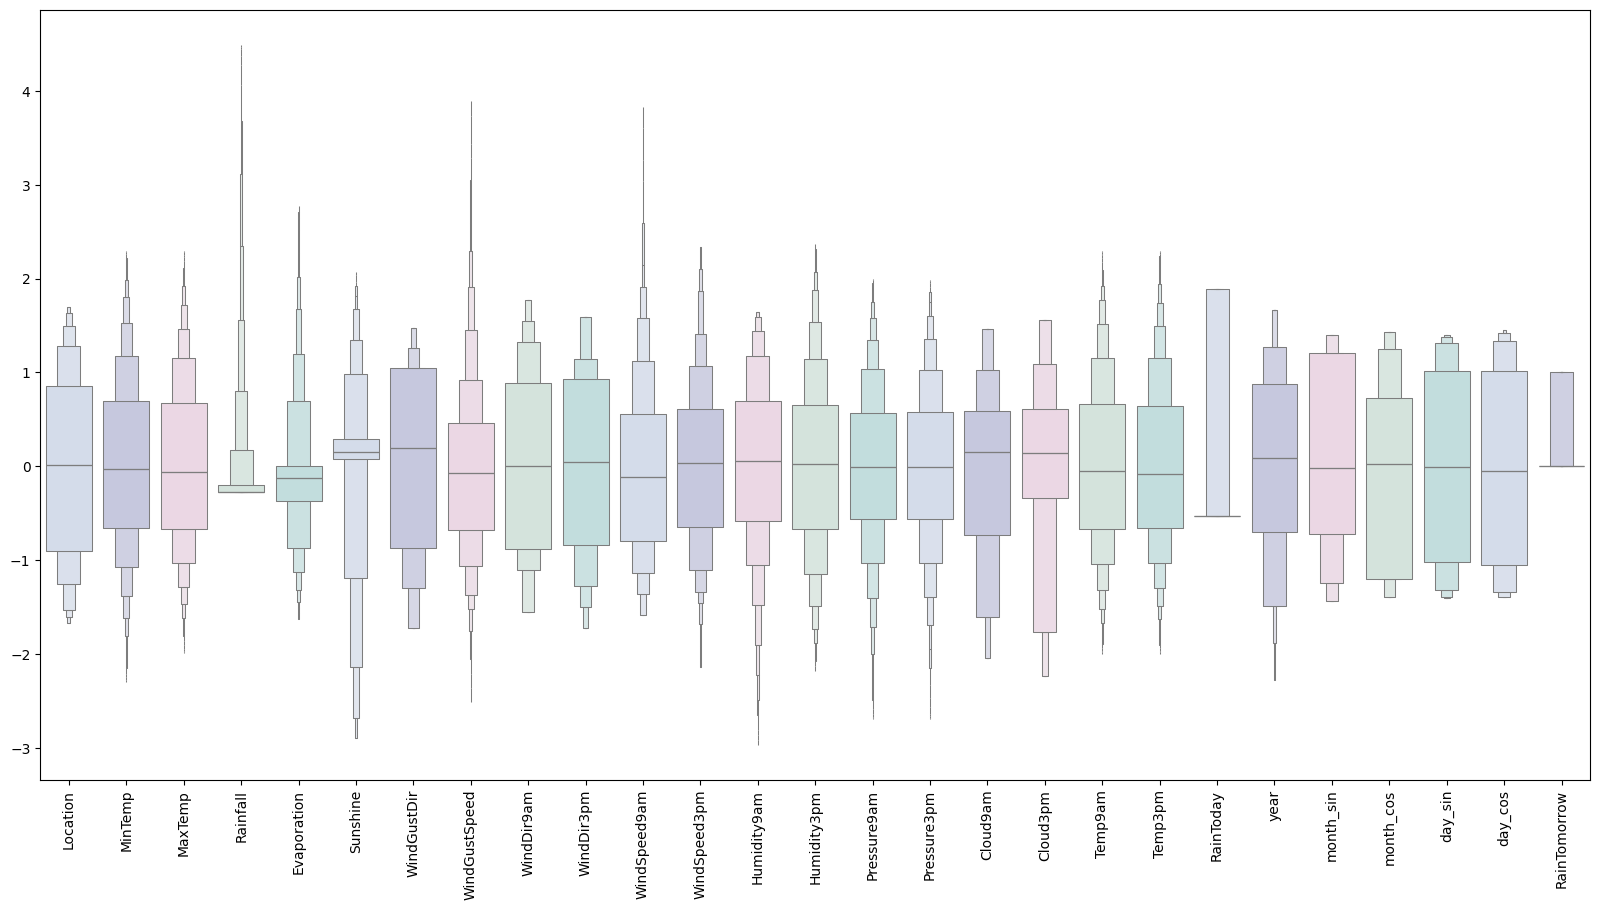

In [23]:
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

Looks Good. Up next is building artificial neural network.


 # MODEL BUILDING


**In this project, we build an artificial neural network.**

**Following steps are involved in the model building**

* Assining X and y the status of attributes and tags
* Splitting test and training sets
* Initialising the neural network
* Defining by adding layers
* Compiling the neural network
* Train the neural network

In [24]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(127536, 26)

## Neural Network Hyperparameter Optimizations and Their Impact

Below are the optimizations made to improve the performance of the neural network model, resulting in an accuracy increase from **79% to 85%**:

### 1. **Weight Initialization**
- **Before:** `kernel_initializer='he_normal'`
- **After:** `kernel_initializer='uniform'`
- **Impact:** `uniform` can sometimes yield better starting weights in shallow networks, especially when activation functions like ReLU are used. The difference may help convergence depending on data distribution.

### 2. **Regularization**
- **Before:** `kernel_regularizer=regularizers.l2(0.001)`
- **After:** Removed L2 regularization
- **Impact:** While L2 regularization prevents overfitting, removing it can allow the model to fit more closely to the data—useful when underfitting was an issue.

### 3. **Dropout Rate**
- **Before:** `Dropout(0.2)` and `Dropout(0.3)`
- **After:** Increased to `Dropout(0.25)` and `Dropout(0.5)`
- **Impact:** Higher dropout rates help reduce overfitting by forcing the network to learn more robust features.

### 4. **Learning Rate**
- **Before:** `learning_rate=0.0005`
- **After:** `learning_rate=0.00009`
- **Impact:** A smaller learning rate leads to more stable and finer-grained updates, which can improve final accuracy at the cost of longer training time.

### 5. **Batch Size**
- **Before:** `batch_size=64`
- **After:** `batch_size=32`
- **Impact:** Smaller batches can improve generalization and result in more robust gradient estimates, though training may take longer.

### 6. **Removed AUC Metric**
- **Before:** `metrics=['accuracy', AUC()]`
- **After:** `metrics=['accuracy']`
- **Impact:** This change doesn't affect model training itself but simplifies evaluation and might marginally speed up training.

These adjustments cumulatively led to better generalization and higher validation accuracy.


In [25]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7842 - loss: 0.5659 - val_accuracy: 0.7860 - val_loss: 0.3945
Epoch 2/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7839 - loss: 0.4159 - val_accuracy: 0.7860 - val_loss: 0.3877
Epoch 3/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7838 - loss: 0.4113 - val_accuracy: 0.7860 - val_loss: 0.3847
Epoch 4/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7875 - loss: 0.4012 - val_accuracy: 0.7860 - val_loss: 0.3829
Epoch 5/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7840 - loss: 0.4065 - val_accuracy: 0.7860 - val_loss: 0.3810
Epoch 6/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8298 - loss: 0.4035 - val_accuracy: 0.8389 - val_loss: 0.3798
Epoch 7/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8373 - loss: 0.4046 - val_accuracy: 0.8402 - val_loss: 0.3788
Epoch 8/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8382 - loss

Plotting training and validation loss over epochs

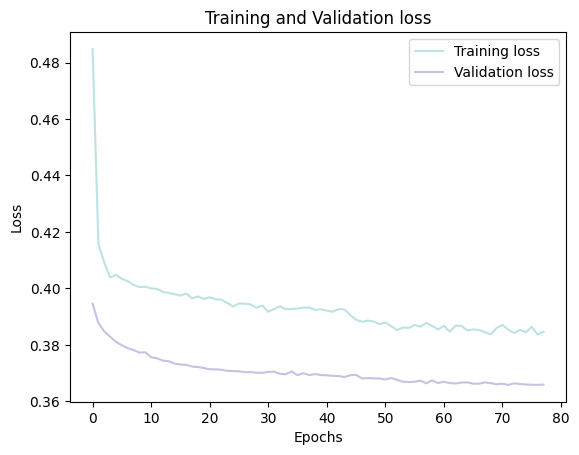

In [26]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

Plotting training and validation accuracy over epochs

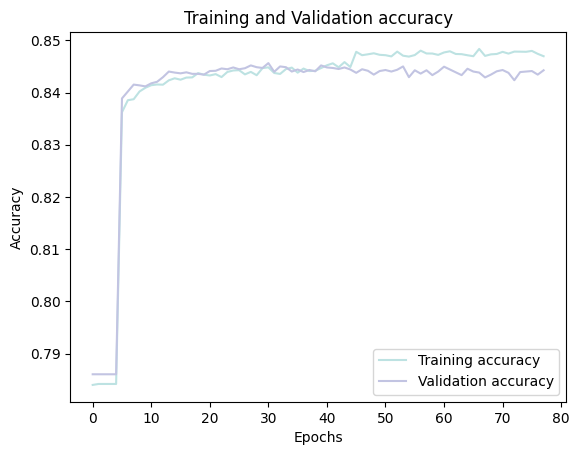

In [27]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# CONCLUSIONS


**Concluding the model with:**

* Testing on the test set
* Evaluating the confusion matrix
* Evaluating the classification report
* Explaining the model with SHAP

In [28]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

798/798 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


<Axes: >

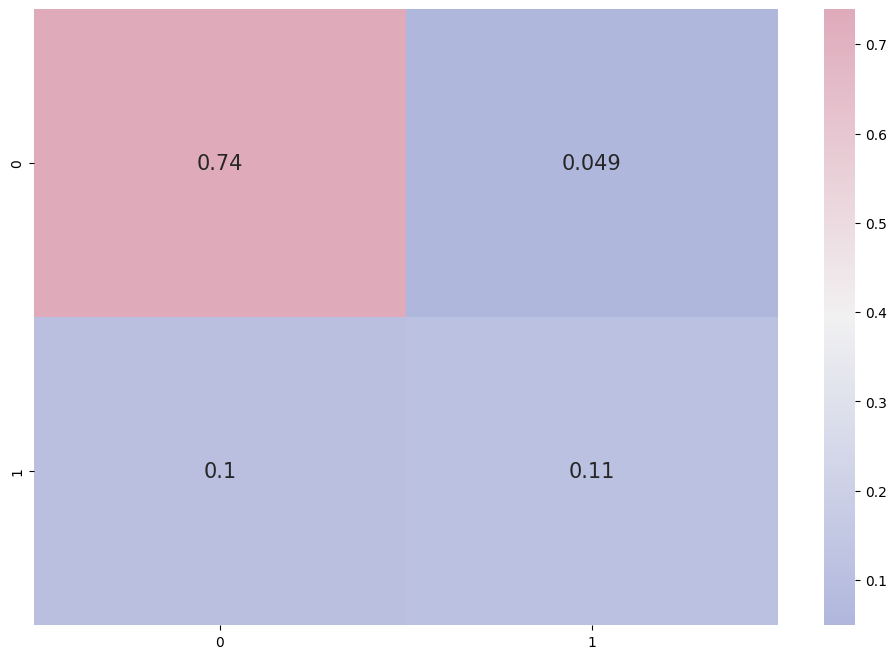

In [31]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     20110
           1       0.69      0.52      0.60      5398

    accuracy                           0.85     25508
   macro avg       0.79      0.73      0.75     25508
weighted avg       0.84      0.85      0.84     25508

